In [10]:
import sys

sys.path.append("../libs")


CONFIG = {
    "model_path": "../data/model/model_calibrated.joblib",
    "features_path": '../data/model/baseline_features_list.json'
}

## Load Model

In [11]:
import joblib

model = joblib.load(CONFIG["model_path"])

In [12]:
import json

with open(CONFIG["features_path"], 'r') as f:
    features = json.load(f)
features

['funded_amnt',
 'term',
 'installment',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl'

## Predict

In [13]:
import pandas as pd


df  = pd.read_parquet('../data/lending_club_case_case_test_dataset.parquet')

In [14]:
df['time_of_banking_days'] = (df['issue_d'] - df['earliest_cr_line']).dt.days
df['time_of_banking_months'] = (df['issue_d'].dt.year - df['earliest_cr_line'].dt.year) * 12 + (df['issue_d'].dt.month - df['earliest_cr_line'].dt.month)

In [15]:
cat_features = [
    "emp_length",
    "home_ownership",
    "verification_status",
    "purpose",
    "addr_state",
    "application_type",
]

In [16]:
X = df[features]

In [17]:
X[cat_features] = X[cat_features].astype(str).fillna('missing')


/var/folders/tc/7v_6yrg96fgdxwydpsmdqhz40000gn/T/ipykernel_5851/1685576383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_features] = X[cat_features].astype(str).fillna('missing')


In [41]:
df["default_prob"] = model.predict_proba(X)[:, 1]
df["default"] = model.predict(X)

<Axes: >

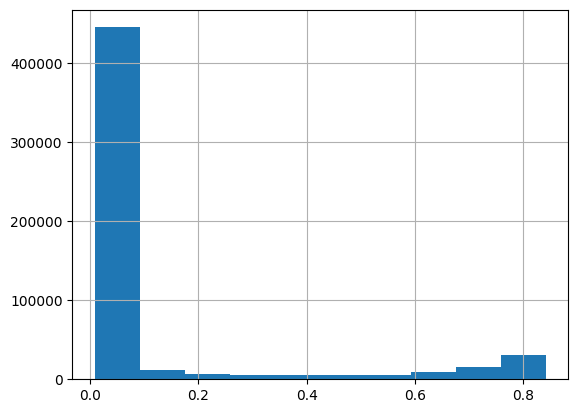

In [63]:
df["default_prob"].hist()

In [64]:
df = df[df['default'] == 1]

In [65]:
df['risk_category'], bins = pd.qcut(df["default_prob"], 8, labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], retbins=True)


In [66]:
df['principal'] = df['loan_amnt'] * (1 + df["int_rate"])


In [67]:
df['ead'] = df['principal'] - df.total_pymnt
df['ead_ratio'] = df['ead'] / df['principal']

df['lgd_ratio'] = 1 - (df['recoveries'] / df['ead'])

# Final Losses
df['losses'] = (
    df['principal']
    - df.total_pymnt
    + df['recoveries']
)

In [68]:
df["addr_state"]

472066     NY
472078     NY
472080     NY
472086     MD
472095     NH
           ..
1082944    WA
1082945    CA
1082954    FL
1082963    GA
1082979    CA
Name: addr_state, Length: 60590, dtype: category
Categories (51, object): ['AK', 'AL', 'AR', 'AZ', ..., 'WA', 'WI', 'WV', 'WY']

In [80]:
default_table = df.groupby(['risk_category', 'term']).agg(
    default_ratio=('default_prob','mean'),
    int_rate=('int_rate', 'mean'),
    principal=('principal','mean'),
    total=('id', 'count')
).reset_index()

/var/folders/tc/7v_6yrg96fgdxwydpsmdqhz40000gn/T/ipykernel_5851/1736364223.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_table = df.groupby(['risk_category', 'term']).agg(


In [81]:
policy_table = df[df.default == 1].groupby(['risk_category', 'term']).agg(
    EAD=('ead_ratio', 'mean'),
    LGD=('lgd_ratio', 'mean'),
    total_default=('id', 'count'),
    int_rate_default=('int_rate', 'mean'),
).reset_index()

policy_table = pd.merge(policy_table, default_table, on=['risk_category', 'term'])

/var/folders/tc/7v_6yrg96fgdxwydpsmdqhz40000gn/T/ipykernel_5851/3265944805.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  policy_table = df[df.default == 1].groupby(['risk_category', 'term']).agg(


In [82]:
policy_3 = policy_table.loc[policy_table.term == 36].copy()

policy_5 = policy_table.loc[policy_table.term == 60].copy()

In [83]:
policy_3


,risk_category,term,EAD,LGD,total_default,int_rate_default,default_ratio,int_rate,principal,total
0,A,36,0.461394,0.93372,5509,0.141533,0.555149,0.141533,13946.656572,5509
2,B,36,0.500874,0.933151,5677,0.143392,0.641984,0.143392,14203.923779,5677
4,C,36,0.538602,0.92273,5780,0.144527,0.701279,0.144527,14886.689449,5780
6,D,36,0.566965,0.922285,5570,0.143856,0.741665,0.143856,15840.082333,5570
8,E,36,0.588783,0.930162,5092,0.145947,0.770892,0.145947,16899.159494,5092
10,F,36,0.613581,0.932157,3922,0.149249,0.793189,0.149249,19264.410354,3922
12,G,36,0.647637,0.932161,1490,0.156275,0.809933,0.156275,24682.319123,1490
14,H,36,0.60109,0.9308,219,0.145931,0.827586,0.145931,23966.249064,219


In [84]:
policy_5

,risk_category,term,EAD,LGD,total_default,int_rate_default,default_ratio,int_rate,principal,total
1,A,60,0.520808,0.977914,2065,0.174937,0.553906,0.174937,24705.800143,2065
3,B,60,0.534635,0.971758,1897,0.172920,0.642341,0.172920,24529.79894,1897
5,C,60,0.552364,0.963612,1793,0.177060,0.700992,0.177060,24581.175682,1793
7,D,60,0.578905,0.917473,2004,0.175631,0.742128,0.175631,24307.995033,2004
9,E,60,0.608519,0.946487,2482,0.174922,0.771576,0.174922,24750.025427,2482
11,F,60,0.644339,0.930174,3651,0.174524,0.794660,0.174524,24819.364424,3651
13,G,60,0.66752,0.924173,6084,0.177094,0.812852,0.177094,25285.288256,6084
15,H,60,0.695202,0.918819,7355,0.187089,0.827690,0.187089,26774.529936,7355


## Write

In [41]:
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,time_of_banking_days,time_of_banking_months,default_prob
472065,130607974,14100,14100,14096.0,36,0.238647,552.00,E,E2,Sr Clinical Research Associate,...,-1,-1,NaN,-1.0,-1.0,-1.0,N,4656,153,0.012474
472066,130932509,20000,20000,20000.0,60,0.140747,466.00,C,C3,TEACHER,...,-1,-1,NaN,-1.0,-1.0,-1.0,N,5630,185,0.975943
472067,130938452,28625,28625,28624.0,60,0.218506,788.00,D,D5,Psychologist,...,-1,-1,NaN,-1.0,-1.0,-1.0,N,8735,287,0.077849
472068,130950844,20000,20000,20000.0,60,0.099182,424.25,B,B2,Manager,...,-1,-1,NaN,-1.0,-1.0,-1.0,N,4899,161,0.533055
472069,130966126,15000,15000,15000.0,60,0.174683,376.50,D,D1,CCAP Administrator,...,-1,-1,NaN,-1.0,-1.0,-1.0,N,10286,338,0.060284
